In [1]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [12]:
images = sorted(glob("/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/cfar_cpp/Analysis/test_UWR/*"))

In [28]:

import math

from scipy.optimize import root

def soca(img, train_hs, guard_hs, tau):
  print(train_hs)
  """
  Implements Sum-Oriented Constant Amplitude filter based on NumPy.

  Args:
    img: Input image as a NumPy array (assumed to be BGR or grayscale).
    train_hs: Training window half-size.
    guard_hs: Guard window half-size.
    tau: Threshold parameter.

  Returns:
    A 2D NumPy array with filtered binary image.
  """

  # Convert OpenCV image to NumPy array and grayscale (if necessary)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
  blurred_image = cv2.GaussianBlur(img_gray, (7, 7), 0)
  denoised_image = cv2.fastNlMeansDenoising(blurred_image, h=200)


  rows, cols = denoised_image.shape
  ret = np.zeros((rows, cols), dtype=np.uint8)

  for col in range(cols):
    for row in range(train_hs + guard_hs, rows - train_hs - guard_hs):
      leading_sum, lagging_sum = 0.0, 0.0
      for i in range(row - train_hs - guard_hs, row + train_hs + guard_hs + 1):
        if (i - row) > guard_hs:
          lagging_sum += denoised_image[i, col]
        else:
          leading_sum += denoised_image[i, col]
      sum_train = np.min([leading_sum, lagging_sum])
      ret[row, col] = (tau * sum_train / train_hs)

  return ret

def goca(img, train_hs, guard_hs, tau):
  """
  Implements Sum-Oriented Constant Amplitude filter based on NumPy.

  Args:
    img: Input image as a NumPy array (assumed to be BGR or grayscale).
    train_hs: Training window half-size.
    guard_hs: Guard window half-size.
    tau: Threshold parameter.

  Returns:
    A 2D NumPy array with filtered binary image.
  """

  # Convert OpenCV image to NumPy array and grayscale (if necessary)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
  blurred_image = cv2.GaussianBlur(img_gray, (7, 7), 0)
  denoised_image = cv2.fastNlMeansDenoising(blurred_image, h=200)

  rows, cols = denoised_image.shape
  ret = np.zeros((rows, cols), dtype=np.uint8)

  for col in range(cols):
    for row in range(train_hs + guard_hs, rows - train_hs - guard_hs):
      leading_sum, lagging_sum = 0.0, 0.0
      for i in range(row - train_hs - guard_hs, row + train_hs + guard_hs + 1):
        if (i - row) > guard_hs:
          lagging_sum += denoised_image[i, col]
        else:
          leading_sum += denoised_image[i, col]
      sum_train = np.max([leading_sum, lagging_sum])
      ret[row, col] = ((tau * sum_train / train_hs))

  return ret
class CFAR(object):
      """
      Constant False Alarm Rate (CFAR) detection with several variants
          - Cell averaging (CA) CFAR
          - Greatest-of cell-averaging (GOCA) CFAR
          - Order statistic (OS) CFAR
      """

      def __init__(self, Ntc, Ngc, Pfa, rank=None):
          self.Ntc = Ntc #number of training cells
          assert self.Ntc % 2 == 0
          self.Ngc = Ngc #number of guard cells
          assert self.Ngc % 2 == 0
          self.Pfa = Pfa #false alarm rate
          if rank is None: #matrix rank
              self.rank = self.Ntc / 2
          else:
              self.rank = rank
              assert 0 <= self.rank < self.Ntc

          #threshold factor calculation for the 4 variants of CFAR
          self.threshold_factor_SOCA = self.calc_WGN_threshold_factor_SOCA()
          self.threshold_factor_GOCA = self.calc_WGN_threshold_factor_GOCA()


          self.params = {
              
              "SOCA": (self.Ntc // 2, self.Ngc // 2, self.threshold_factor_SOCA),
              "GOCA": (self.Ntc // 2, self.Ngc // 2, self.threshold_factor_GOCA),

          }
          self.detector = {
              
              "SOCA": soca,
              "GOCA": goca,
          
          }
        

      def __str__(self):
          return "".join(
              [
                  "CFAR Detector Information\n",
                  "=========================\n",
                  "Number of training cells: {}\n".format(self.Ntc),
                  "Number of guard cells: {}\n".format(self.Ngc),
                  "Probability of false alarm: {}\n".format(self.Pfa),
                  "Order statictics rank: {}\n".format(self.rank),
                  "Threshold factors:\n",
                
                  "    SOCA-CFAR: {:.3f}\n".format(self.threshold_factor_SOCA),
                  "    GOCA-CFAR: {:.3f}\n".format(self.threshold_factor_GOCA),
          
              ]
          )

      def calc_WGN_threshold_factor_CA(self):
          return self.Ntc * (self.Pfa ** (-1.0 / self.Ntc) - 1)

      def calc_WGN_threshold_factor_SOCA(self):
          x0 = self.calc_WGN_threshold_factor_CA()
          for ratio in np.logspace(-2, 2, 10):
              ret = root(self.calc_WGN_pfa_SOCA, x0 * ratio)
              if ret.success:
                  return ret.x[0]
          raise ValueError("Threshold factor of SOCA not found")

      def calc_WGN_threshold_factor_GOCA(self):
          x0 = self.calc_WGN_threshold_factor_CA()
          for ratio in np.logspace(-2, 2, 10):
              ret = root(self.calc_WGN_pfa_GOCA, x0 * ratio)
              if ret.success:
                  return ret.x[0]
          raise ValueError("Threshold factor of GOCA not found")

      def calc_WGN_pfa_GOSOCA_core(self, x):
          x = float(x)
          temp = 0.0
          for k in range(int(self.Ntc / 2)):
              l1 = math.lgamma(self.Ntc / 2 + k)
              l2 = math.lgamma(k + 1)
              l3 = math.lgamma(self.Ntc / 2)
              temp += math.exp(l1 - l2 - l3) * (2 + x / (self.Ntc / 2)) ** (-k)
          return temp * (2 + x / (self.Ntc / 2)) ** (-self.Ntc / 2)

      def calc_WGN_pfa_SOCA(self, x):
          return self.calc_WGN_pfa_GOSOCA_core(x) - self.Pfa / 2

      def calc_WGN_pfa_GOCA(self, x):
          x = float(x)
          temp = (1.0 + x / (self.Ntc / 2)) ** (-self.Ntc / 2)
          return temp - self.calc_WGN_pfa_GOSOCA_core(x) - self.Pfa / 2


      def detect(self, mat, alg="CA"):
          """
          Return target mask array.
          """
          #pad_width = [(self.Ntc//2 + self.Ngc//2, self.Ntc//2 + self.Ngc//2), (self.Ntc//2 + self.Ngc//2, self.Ntc//2 + self.Ngc//2)]
          #mat=np.pad(mat, pad_width=pad_width, mode='constant', constant_values=0)
          return self.detector[alg](mat, *self.params[alg])

def soca_code(soca_trial):

  # img_gray=cv2.imread("test.png",0)
  img = soca_trial
  cfar_obj=CFAR(14,6,0.90) 

  cfar_result=cfar_obj.detect(img,alg="SOCA")
  return cfar_result 

In [93]:
test_img=cv2.imread(images[0],0)[150:,200:300]

In [94]:
test_img.shape

(280, 100)

In [36]:
filter=soca_code(test_img)

/tmp/ipykernel_408692/2312096224.py:152: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(x)
/tmp/ipykernel_408692/2312096224.py:165: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(x)


7


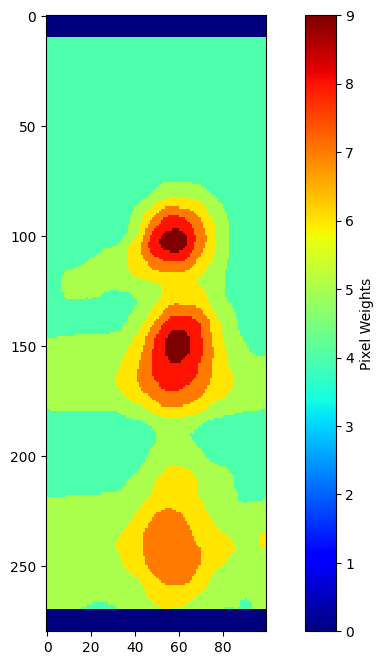

In [37]:
plt.figure(figsize=(10, 8))
plt.imshow(filter, cmap='jet', interpolation='nearest')
plt.colorbar(label='Pixel Weights')

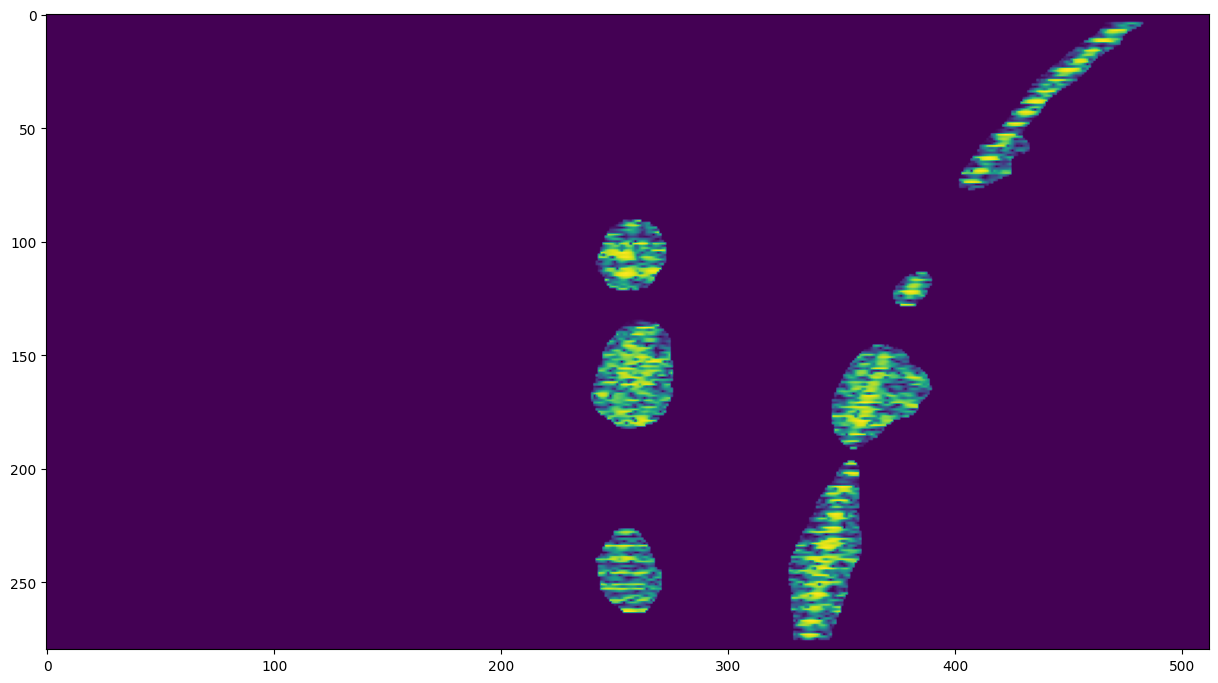

In [23]:
test_cluster=filter>=8
denoised=test_cluster*test_img
hist_denoised=(cv2.equalizeHist(denoised))
plt.figure(figsize=(15,15))
plt.imshow(hist_denoised)

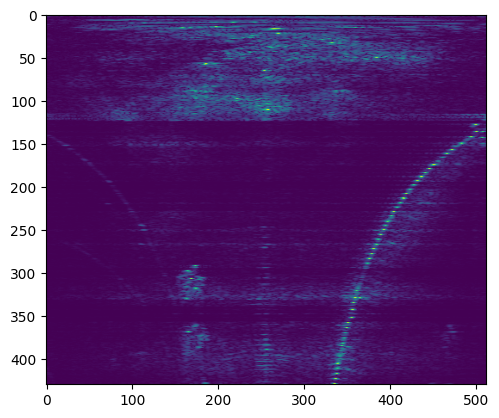

In [49]:
img=cv2.imread(images[5],0)
plt.imshow(img)

In [125]:
num=100
avg_img=np.array(test_img,np.float32)
for img_path in images[:num]:
    img=cv2.imread(img_path,0)[150:]
    filter=soca_code(img)
    test_cluster=filter>=4
    denoised=test_cluster*test_img
    avg_img+=denoised


/tmp/ipykernel_371181/982430499.py:152: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(x)
/tmp/ipykernel_371181/982430499.py:165: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(x)


3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


In [136]:
filter_img=(avg_img/num)>80

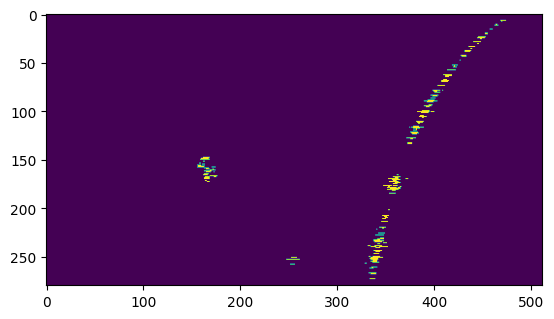

In [137]:
plt.imshow(filter_img)

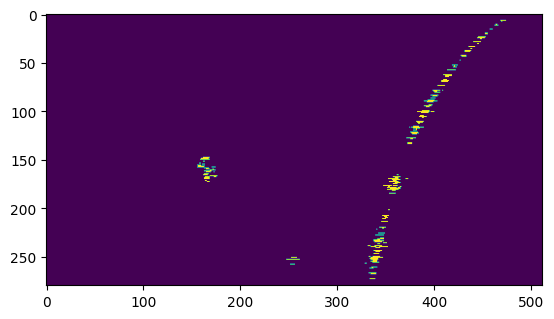

In [132]:
plt.imshow(filter_img)

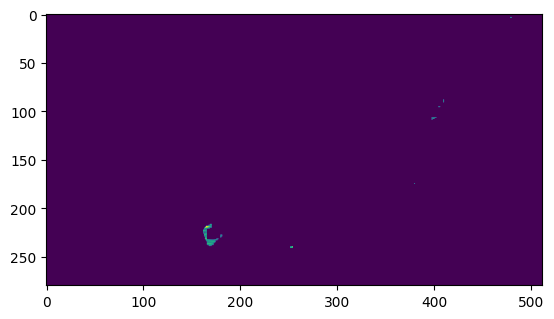

In [122]:
mask=np.array((1-filter_img),np.uint8)
kernel=np.ones((5,5))
dilated_mask=cv2.erode(mask,kernel=kernel,iterations=2)
plt.imshow(dilated_mask*denoised)  #denoised derived from test_img

In [7]:
dilated_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [104]:
path="/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/cfar_cpp/Analysis/UWR3"
os.makedirs(path,exist_ok=True)
i=0
for img_path in images[:]:
    
    img=cv2.imread(img_path,0)[150:,200:300]
    img1=soca_code(img)
    test_cluster=img1>=5
    denoised=test_cluster*img
    hist_denoised=(cv2.equalizeHist(denoised))

    #plt.figure()
    #plt.imshow(final_img)
    cv2.imwrite(path+"/"+f"{i:03d}"+".png",hist_denoised)
    i+=1


/tmp/ipykernel_408692/2312096224.py:152: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(x)
/tmp/ipykernel_408692/2312096224.py:165: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(x)


7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7


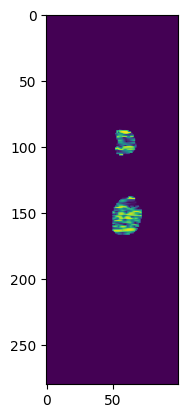

In [69]:
plt.imshow(hist_denoised)

In [61]:
image_times=sorted(glob("/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/Jannah FYP/Documents/Sonar Repositories/soca_test/Polar Input/fls_images_polar/*.png"))

In [24]:
image_times_last=[int(x.split("/")[-1].split(".")[0]) for x in image_times]

In [27]:
times=np.array(image_times_last)

In [33]:
np.mean(np.diff(times)[:]/np.power(10,9))

2.3682891576917475

In [105]:
cleaned_images=sorted(glob("/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/cfar_cpp/Analysis/UWR3/*.png"))
cleaned_images

['/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/cfar_cpp/Analysis/UWR3/000.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/cfar_cpp/Analysis/UWR3/001.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/cfar_cpp/Analysis/UWR3/002.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/cfar_cpp/Analysis/UWR3/003.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/cfar_cpp/Analysis/UWR3/004.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/cfar_cpp/Analysis/UWR3/005.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/cfar_cpp/Analysis/UWR3/006.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/cfar_cpp/Analysis/UWR3/007.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/cfar_cpp/Analysis/UWR3/008.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/cfar_cpp/Analysis/UWR3/009.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/cfar_cpp/Analysis/UWR3/010.png',
 '/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/cfar_cpp/Analysis/UWR3/01

In [109]:
cxs=[]
cys=[]
for image_path in range(0,len(cleaned_images),5):
    print(image_path)
    image=cv2.imread(cleaned_images[image_path])
    binary=cv2.imread(cleaned_images[image_path],0)
    moments = cv2.moments(binary)

    # Check if there is any mass (to avoid division by zero)
    if moments['m00'] != 0:
        # Calculate the centroid
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
        #print(f"Centroid of the blob is at: ({cx}, {cy})")
    else:
        print("No blob detected!")

    # Optionally visualize the centroid on the image
    output = image.copy()
    cv2.circle(output, (cx, cy), 5, (0, 0, 255), -1)  # Draw a red dot
    cxs.append(cx)
    cys.append(cy)
#plt.imshow(output)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160


In [110]:
imag

NameError: name 'imag' is not defined

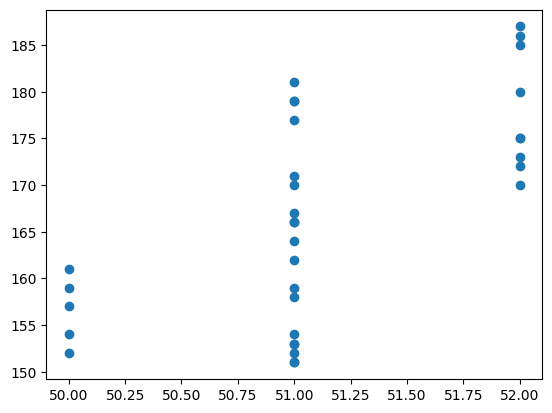

In [112]:
plt.scatter(cxs,cys)

Text(0, 0.5, 'UWR distance from FLS (m)')

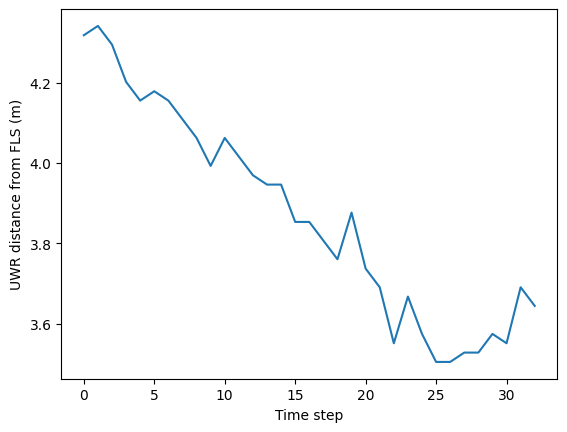

In [113]:
plt.plot(np.array(cys)/280*6.5)
plt.xlabel("Time step")
plt.ylabel("UWR distance from FLS (m)")

/tmp/ipykernel_408692/2312096224.py:152: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(x)
/tmp/ipykernel_408692/2312096224.py:165: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(x)


7
7


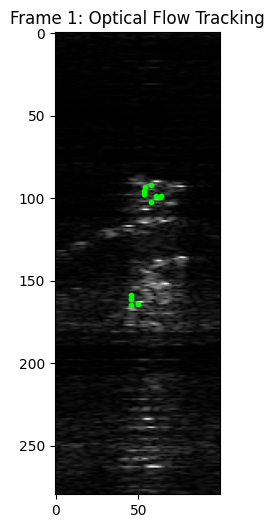

7


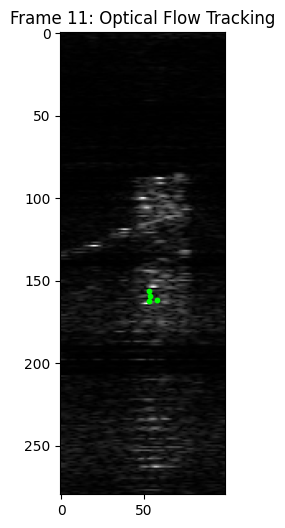

7


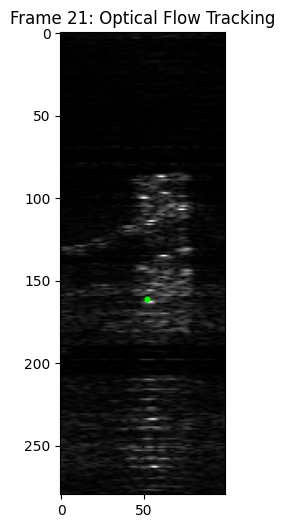

7


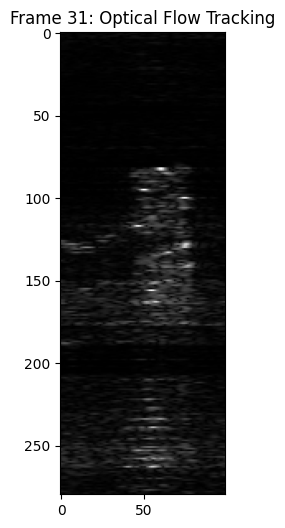

7
too static
7
too static
7
too static
7
too static
7
too static
7
too static
7
too static
7
too static
7
too static
7
too static
7
too static
7
too static
7
too static


In [48]:


# Optical flow parameters
lk_params = dict(winSize=(15, 15), maxLevel=3,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 15, 0.01))

# Shi-Tomasi feature detection parameters
feature_params = dict(maxCorners=500, qualityLevel=0.1, minDistance=1, blockSize=7)

# Read the first frame
prev_frame = cv2.imread(images[0], cv2.IMREAD_GRAYSCALE)[150:,200:300]
filtered=soca_code(prev_frame)
test_cluster=filtered>=8
denoised=test_cluster*prev_frame
hist_denoised_prev = cv2.equalizeHist(denoised)  # Enhance contrast

# Detect bright features in the CFAR image
mask = hist_denoised_prev > np.percentile(hist_denoised_prev, 95)  # Take top 5% brightest pixels
keypoints = cv2.goodFeaturesToTrack(hist_denoised_prev, mask=mask.astype(np.uint8), **feature_params)

# Optical flow tracking loop
for i in range(1, len(images),10):
    try:
        curr_frame = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE)[150:,200:300]
        filtered=soca_code(curr_frame)
        test_cluster=filtered>=8
        denoised=test_cluster*curr_frame
        hist_denoised = cv2.equalizeHist(denoised)  # Enhance contrast

        # Compute optical flow
        new_points, status, err = cv2.calcOpticalFlowPyrLK(hist_denoised_prev, hist_denoised, keypoints, None, **lk_params)

        # Filter valid points
        valid_old = keypoints[status == 1]
        valid_new = new_points[status == 1]

        # Compute motion vectors
        motion_vectors = valid_new - valid_old
        magnitudes = np.linalg.norm(motion_vectors, axis=1)

        # Filter out small movements (likely noise or static objects)
        threshold = np.percentile(magnitudes, 70)  # Keep only top 30% strongest movements
        moving_points = valid_new[magnitudes > threshold]

        # Plot results in Jupyter
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(curr_frame, cmap='gray')
        
        # Draw motion vectors
        for pt in moving_points:
            ax.scatter(pt[0], pt[1], c='lime', s=10)  # Green for detected motion

        ax.set_title(f"Frame {i}: Optical Flow Tracking")
        plt.show()

        # Update for next frame
        hist_denoised_prev = hist_denoised.copy()
        keypoints = moving_points.reshape(-1, 1, 2) if len(moving_points) > 0 else None
    except:
        print("too static")


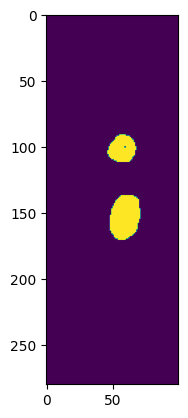

In [43]:
plt.imshow(mask)